In [1]:
%load_ext autoreload
%autoreload 2

from multiprocessing import cpu_count
import os
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.loggers.neptune import NeptuneLogger
import ray
import seaborn
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from nemo.data.dataloader import TrialAvgNeuralDataset
from nemo.model.analysis.feature_visualization import write_simple_cell_strfs
from nemo.model.models import ElasticNet
from nemo.model.layers import Identity
from nemo.model.utils import tune_model

# "Population" Model

## Set Parameters

Hyper-parameter values to search over

In [2]:
alphas = ray.tune.uniform(0.0, 1.0)
lambdas = ray.tune.loguniform(1e-8, 1.0)
lrs = ray.tune.loguniform(1e-5, 1e-1)
batch_sizes = 512
loss_fns = torch.nn.MSELoss()
input_norms = torch.nn.BatchNorm1d
act_norms = ray.tune.choice([
    torch.nn.BatchNorm1d,
    torch.nn.LayerNorm,
    None
])
optims = torch.optim.SGD
act_fns = None
n_tune_samples = 50

Dataset Parameters

In [3]:
n_frames = 9
stim_height = 40 
stim_width = 64
train_stim = ['natural_movie_three']
val_stim = ['natural_movie_two']
test_stim = ['natural_movie_one']

Data Loader Parameters

In [4]:
n_workers = 10

Trainer and Model Args

In [5]:
n_gpu_tune = 1
max_steps = 10000
n_cpu_tune = 6
patience = 5
tol = 1e-4

## Initialize the Dataset

In [6]:
dset = TrialAvgNeuralDataset(
    data_dir = '../../data/AIBO/VISp/L4/Exc/ExtractedData',
    stimuli = train_stim + val_stim + test_stim,
    stim_height = stim_height,
    stim_width = stim_width,
    n_frames = n_frames,
    col_transform = lambda x: x.subtract(x.mean())
)

INFO -- 04/05/2021 12:37:53 PM -- Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
/home/mteti/NEMO/nemo/model/analysis/metrics.py:164: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(SP / true.groupby('stimulus').var())
INFO -- 04/05/2021 12:39:28 PM -- DATASET INITIALIZED
INFO -- 04/05/2021 12:39:28 PM --    - NEURAL DATA DIR: ../../data/AIBO/VISp/L4/Exc/ExtractedData/NeuralData
INFO -- 04/05/2021 12:39:28 PM --    - STIMULI DATA DIR: ../../data/AIBO/VISp/L4/Exc/ExtractedData/Stimuli
INFO -- 04/05/2021 12:39:28 PM --    - STIMULI: ['natural_movie_three', 'natural_movie_two', 'natural_movie_one']
INFO -- 04/05/2021 12:39:28 PM --    - CRE LINES: None
INFO -- 04/05/2021 12:39:28 PM --    - NUM. CELLS: 5353
INFO -- 04/05/2021 12:39:28 PM --    - NUM. ANIMALS: 45
INFO -- 04/05/2021 12:39:28 PM --    - NUM. STIMULUS FRAMES: 5400


In [7]:
dset.data

,stimulus,frame,517397343_511498742,517397347_511498742,517397357_511498742,517397441_511498742,517397464_511498742,517397474_511498742,517397528_511498742,517397564_511498742,...,738948440_712178509,738948535_712178509,738948566_712178509,738948605_712178509,738948646_712178509,738948685_712178509,738948725_712178509,738948770_712178509,738948842_712178509,738948929_712178509
0,natural_movie_one,0.0,-0.006355,-0.003105,-0.008530,-0.014091,-0.004967,-0.005760,0.038544,-0.003147,...,-0.006142,-0.005089,-0.008377,-0.006287,-0.003801,-0.007137,-0.006653,0.004971,-0.004631,-0.009140
1,natural_movie_one,1.0,0.006813,-0.007034,-0.011215,-0.000605,-0.013840,-0.003445,0.038910,-0.007065,...,0.004585,0.004383,-0.005135,-0.008652,0.008728,-0.003819,0.000147,-0.002247,-0.002602,0.002014
2,natural_movie_one,2.0,-0.002745,-0.012039,-0.011124,-0.005043,-0.000656,-0.009964,0.034454,-0.006058,...,-0.001457,-0.005745,-0.009415,-0.012268,-0.011444,-0.005753,-0.009949,-0.001713,-0.005787,-0.006462
3,natural_movie_one,3.0,0.005852,-0.003403,-0.001801,0.008919,-0.000206,0.001938,0.028564,-0.005737,...,0.002373,0.012421,-0.008698,-0.017044,-0.012283,0.003059,-0.002459,-0.004269,-0.011497,-0.008270
4,natural_movie_one,4.0,0.002052,0.003899,0.003551,0.003305,-0.005711,-0.004169,0.020294,-0.003521,...,-0.000816,0.001968,-0.003227,-0.014801,0.000950,0.000017,0.001202,-0.000650,-0.005310,0.004116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,natural_movie_two,895.0,-0.004822,0.019241,-0.000347,0.002337,0.009346,0.004967,-0.009621,-0.008530,...,0.000320,-0.007645,0.003487,0.014633,0.019989,0.009872,0.006973,0.009735,0.033478,-0.002777
5396,natural_movie_two,896.0,-0.000542,0.016541,-0.005928,-0.000874,0.002014,-0.003105,-0.003256,-0.011581,...,-0.011124,-0.016937,-0.003038,-0.029510,-0.003960,0.006767,0.004875,-0.001265,0.013283,-0.004066
5397,natural_movie_two,897.0,-0.017700,0.019485,-0.002283,0.007179,0.002083,-0.005928,-0.006252,-0.007778,...,-0.011330,0.004757,0.013443,-0.016769,0.024139,-0.014023,0.003578,0.014709,0.005226,-0.020874
5398,natural_movie_two,898.0,0.000740,0.012634,0.000336,-0.002689,0.010902,-0.012947,-0.006863,-0.006565,...,-0.024628,0.001131,-0.002007,-0.011078,-0.005219,0.017273,0.008286,0.004452,0.005348,-0.005318


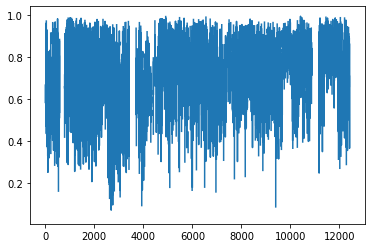

In [8]:
plt.plot(dset.cc_max[dset.cc_max.index == test_stim[0]].to_numpy()[0])

Text(96.0, 0.5, 'Neuron')

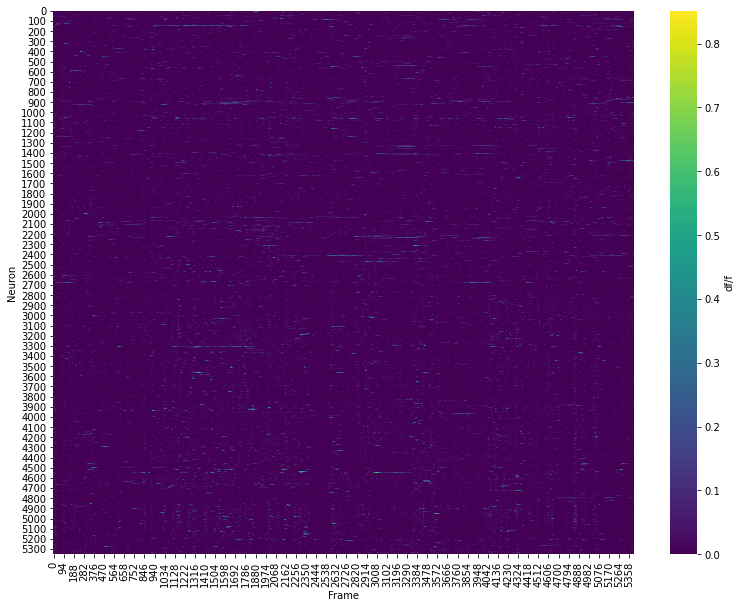

In [9]:
fig = plt.figure(figsize = (13, 10))
seaborn.heatmap(
    data = dset.data.set_index(['stimulus', 'frame']).to_numpy().transpose(),
    cmap = 'viridis',
    vmin = 0.0,
    cbar_kws = {'label': 'df/f'}
)
plt.xlabel('Frame')
plt.ylabel('Neuron')

In [10]:
train_inds = dset.data.index[dset.data.stimulus.isin(train_stim)].to_list()
val_inds = dset.data.index[dset.data.stimulus.isin(val_stim)].to_list()
test_inds = dset.data.index[dset.data.stimulus.isin(test_stim)].to_list()
print(len(train_inds), len(val_inds), len(test_inds), len(set(train_inds) & set(test_inds) & set(val_inds)))

3600 900 900 0


## Run Hyper-Parameter Search

In [11]:
ray.init(include_dashboard = False)

{'node_ip_address': '192.168.1.15',
 'raylet_ip_address': '192.168.1.15',
 'redis_address': '192.168.1.15:6379',
 'object_store_address': '/tmp/ray/session_2021-04-05_12-39-45_946561_29382/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-05_12-39-45_946561_29382/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-04-05_12-39-45_946561_29382',
 'metrics_export_port': 58855,
 'node_id': '78309ca83893fedcf39d5d242647923ea196f751f7c787b1fd7a91c0'}

In [12]:
config = {
    'lr': lrs,
    'alpha': alphas,
    'lambd': lambdas,
    'act_fn': act_fns,
    'loss_fn': loss_fns,
    'optim': optims,
    'input_norm_fn': input_norms,
    'norm_fn': act_norms,
    'batch_size': batch_sizes,
    'n_neurons': len(dset.cell_ids),
    'in_h': stim_height,
    'in_w': stim_width,
    'n_frames': n_frames,
    'patience': patience,
    'tol': tol
}

In [13]:
analysis = ray.tune.run(
    ray.tune.with_parameters(
        tune_model,
        ptl_model = ElasticNet,
        dset = dset,
        train_inds = train_inds,
        val_inds = val_inds,
        n_workers = n_workers,
        tune_metrics = {'loss': 'val_loss'},
        mode = 'tune',
        gpus = n_gpu_tune,
        max_steps = max_steps,
        check_val_every_n_epoch = 1,
        progress_bar_refresh_rate = 0,
        weights_summary = None
    ),
    config = config,
    num_samples = n_tune_samples,
    resources_per_trial = {'cpu': n_cpu_tune, 'gpu': n_gpu_tune},
    verbose = 0, 
    metric = 'loss',
    mode = 'min',
    local_dir = './population_hp_tune_results',
    checkpoint_freq = 0
)

2021-04-05 12:39:47,808	WARNING function_runner.py:541 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
(pid=30098) GPU available: True, used: True
(pid=30098) TPU available: None, using: 0 TPU cores
(pid=30098) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=30100) GPU available: True, used: True
(pid=30100) TPU available: None, using: 0 TPU cores
(pid=30100) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
2021-04-05 12:42:54,839	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'norm_fn': None}
(pid=30102) GPU available: True, used: True
(pid=30102) TPU available: None, using: 0 TPU cores
(pid=30102) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
2021-04-05 12:42:59,839	INFO logger.py:690 -- Removed the following hyperparameter values when logging to tensorboard: {'norm_fn': <clas

KeyboardInterrupt: 

In [22]:
analysis.best_config

{'lr': 0.07291109618049334,
 'alpha': 0.3754391087576646,
 'lambd': 1.5342688630377913e-05,
 'act_fn': None,
 'loss_fn': MSELoss(),
 'optim': torch.optim.sgd.SGD,
 'input_norm_fn': torch.nn.modules.batchnorm.BatchNorm1d,
 'norm_fn': None,
 'batch_size': 512,
 'n_neurons': 5353,
 'in_h': 40,
 'in_w': 64,
 'n_frames': 9,
 'patience': 5,
 'tol': 0.01}

In [23]:
result_df = analysis.results_df

In [24]:
len(result_df)

50

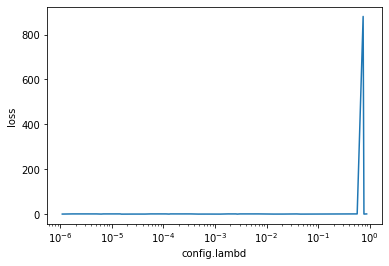

In [25]:
seaborn.lineplot(
    data = result_df,
    x = 'config.lambd',
    y = 'loss'
)
plt.xscale('log')
plt.show()

## Retrain a Model on Train + Val Datasets With Optimal Hyper-parameters

In [32]:
trainer = tune_model(
    config = analysis.best_config,
    ptl_model = ElasticNet,
    dset = dset,
    train_inds = train_inds + val_inds,
    n_workers = cpu_count() - 4,
    val_inds = train_inds + val_inds,
    mode = 'train',
    gpus = n_gpu_tune,
    max_steps = max_steps,
    check_val_every_n_epoch = 1,
    progress_bar_refresh_rate = 50,
    log_every_n_steps = 5,
    logger = NeptuneLogger(
        api_key = os.environ['NEPTUNE_API_TOKEN'],
        project_name = 'mteti/neural-encoding-elasticnet',
        experiment_name = 'population_model',
        params = {
            k: v.real if k in ['alpha', 'lr', 'lambd'] else v 
            for k, v in analysis.best_config.items()
        }
    )
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type        | Params
----------------------------------------------
0 | loss_fn       | MSELoss     | 0     
1 | act_fn        | Identity    | 0     
2 | norm_fn       | Identity    | 0     
3 | input_norm_fn | BatchNorm1d | 46.1 K
4 | strf          | Linear      | 123 M 
----------------------------------------------
123 M     Trainable params
0         Non-trainable params
123 M     Total params
493.538   Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

WARNING -- 04/05/2021 11:06:54 AM -- Experiencing connection interruptions. Reestablishing communication with Neptune.
WARNING -- 04/05/2021 11:06:55 AM -- Experiencing connection interruptions. Reestablishing communication with Neptune.


Epoch 0: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]      
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=2.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=2.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=2.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=2.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=2.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 16/16 [00:29<00:00,  1.85s/it, loss=2.49, v_num=0]


WARNING -- 04/05/2021 11:11:10 AM -- Experiencing connection interruptions. Reestablishing communication with Neptune.
WARNING -- 04/05/2021 11:11:11 AM -- Experiencing connection interruptions. Reestablishing communication with Neptune.


## Test the Model on the Test Movie

### View the Weights

In [33]:
best_model = trainer.get_model()

In [34]:
best_weights = best_model.strf.weight.detach().cpu().numpy()
best_weights = best_weights.reshape([-1, n_frames, stim_height, stim_width])
best_weights = [best_weights[:, frame_num, ...][:, None, None, None] for frame_num in range(n_frames)]
print(best_weights[0].shape)
write_simple_cell_strfs(best_weights, './population_mse_loss_no_bias_one_neuron')

(5353, 1, 1, 1, 40, 64)


### Create a Test Data Loader and Get the Loss on the Test Set

In [35]:
test_dl = DataLoader(
    dset,
    batch_size = analysis.best_config['batch_size'],
    num_workers = n_workers,
    sampler = SequentialSampler(test_inds),
    drop_last = False
)

In [36]:
trainer.test(best_model, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 100%|██████████| 2/2 [00:12<00:00,  6.25s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.13218097388744354}
--------------------------------------------------------------------------------


[{'test_loss': 0.13218097388744354}]

### Predict on Test Samples

In [37]:
preds = np.zeros([len(test_inds), len(dset.cell_ids)])
true = preds.copy()
test_bs = test_dl.batch_size

for batch_num, batch in enumerate(test_dl):
    y = batch[1][-1]
    batch = ([x.cuda() for x in batch[0]], [y.cuda() for y in batch[1]])
    y_hat = best_model.predict_step(batch, batch_num)
    preds[batch_num * test_bs: (batch_num + 1) * test_bs] = y_hat.detach().cpu().numpy()
    true[batch_num * test_bs: (batch_num + 1) * test_bs] = y.numpy()

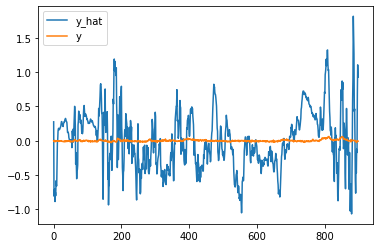

In [38]:
plt.plot(preds[:, 2], label = 'y_hat')
plt.plot(true[:, 2], label = 'y')
plt.legend()
plt.show()